## Target Model
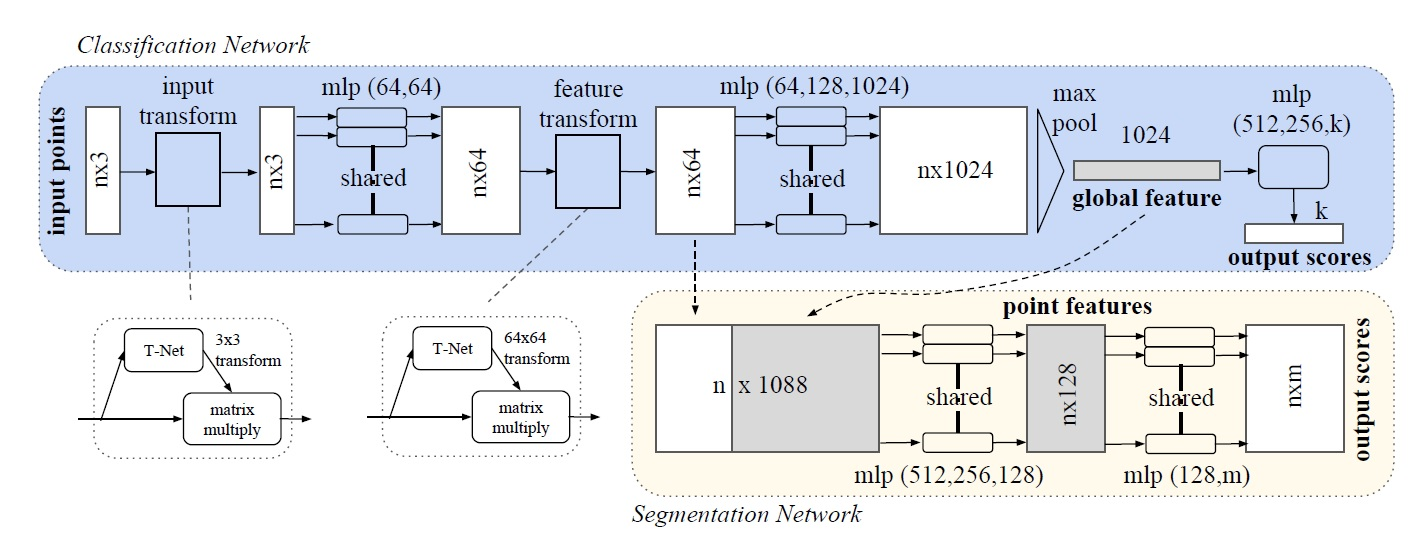



1.  Classification
2.  Segmentation

## Challenges

1.  Complicated Architecture
2.  Did not have any pretrained model with onnx format
3.  Mainly developed with tensorflow. But we were comfortable with pytorch.
4.  API incompatability with pytorch.
5.  Back and forth communication with author to find pytorch source.
6.  Pytorch source was not converted to onnx.
7.  Significant amount of time was invested to prepare a compatible version of onnx.
8.  Make it simpler by removing the segmentation part

## Base verifier : ImageStar
## Challenges

1.   Based on Matlab
2.   Full guidelines to use ImageStar was not available.
3.   Tried to write the concept with pytorch, it seemed we are swiming in ocean
4.   No PoinNet source was available for matlab.  



## Proposed model
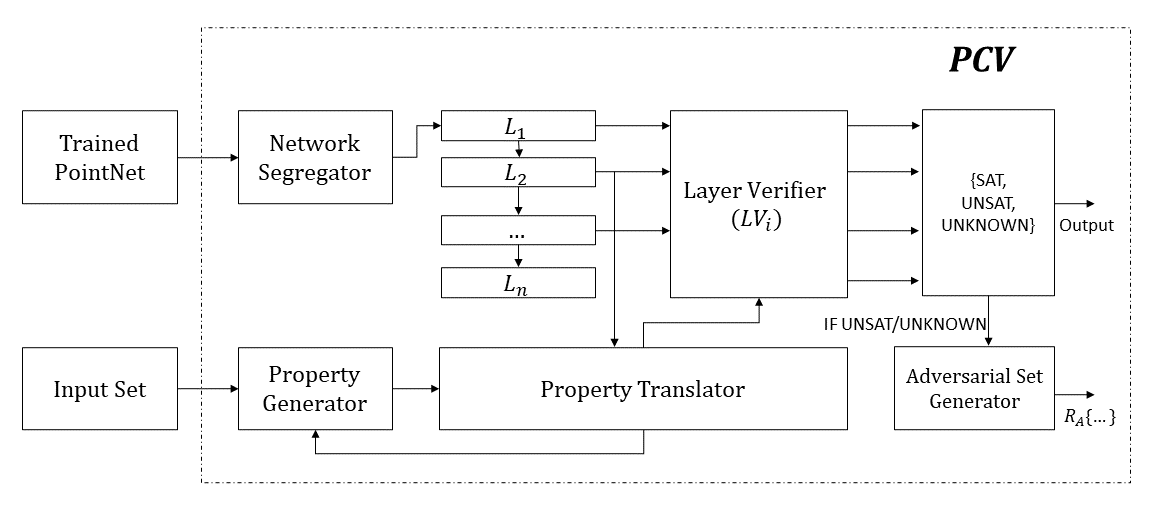



1.   Trained ONNX or PTH model
2.   Input set
3.   Network Segregator
4.   Noise generator 
5.   Layer Verfier
6.   Adversarial Set Generator





## Customized PointNet

In [ ]:
# Date: 25th March, 2022
# Author: Arup Sarker
# Description: A customized pointnet specific for verification.
# Focus on classification accuracy by removing the segmentation part

import torch
import torch.nn as nn
import torch.nn.functional as F


class PCVNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(PCVNet, self).__init__()
        self.output_dim = output_dim

        self.conv_1 = nn.Conv1d(input_dim, 64, 1)
        self.conv_2 = nn.Conv1d(64, 128, 1)
        self.conv_3 = nn.Conv1d(128, 1024, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(128)
        self.bn_3 = nn.BatchNorm1d(1024)
        self.bn_4 = nn.BatchNorm1d(512)
        self.bn_5 = nn.BatchNorm1d(256)

        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, self.output_dim * self.output_dim)

        self.max_pool = nn.MaxPool1d(2)

    def forward(self, x):
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = F.relu(self.bn_3(self.conv_3(x)))
        x = self.max_pool(x)

        x = x.view(-1, 1024)

        x = F.relu(self.bn_4(self.fc_1(x)))
        x = F.relu(self.bn_5(self.fc_2(x)))
        x = self.fc_3(x)

        identity_matrix = torch.eye(self.output_dim)
        if torch.cuda.is_available():
            identity_matrix = identity_matrix.cuda()
        x = x.view(-1, self.output_dim, self.output_dim) + identity_matrix
        return x


class BasePCVNet(nn.Module):
    def __init__(self, point_dimension, return_local_features=False):
        super(BasePCVNet, self).__init__()
        self.return_local_features = return_local_features
        self.input_transform = PCVNet(input_dim=point_dimension, output_dim=point_dimension)
        self.feature_transform = PCVNet(input_dim=64, output_dim=64)

        self.conv_1 = nn.Conv1d(point_dimension, 64, 1)
        self.conv_2 = nn.Conv1d(64, 64, 1)
        self.conv_3 = nn.Conv1d(64, 64, 1)
        self.conv_4 = nn.Conv1d(64, 128, 1)
        self.conv_5 = nn.Conv1d(128, 1024, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(64)
        self.bn_3 = nn.BatchNorm1d(64)
        self.bn_4 = nn.BatchNorm1d(128)
        self.bn_5 = nn.BatchNorm1d(1024)

        self.max_pool = nn.MaxPool1d(2)

    def forward(self, x):
        num_points = x.shape[1]

        input_transform = self.input_transform(x)

        x = torch.bmm(x, input_transform)
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = x.transpose(2, 1)

        feature_transform = self.feature_transform(x)

        x = torch.bmm(x, feature_transform)
        local_point_features = x

        x = x.transpose(2, 1)
        x = F.relu(self.bn_3(self.conv_3(x)))
        x = F.relu(self.bn_4(self.conv_4(x)))
        x = F.relu(self.bn_5(self.conv_5(x)))
        x = self.max_pool(x)

        x = x.view(-1, 1024)

        if self.return_local_features:
            x = x.view(-1, 1024, 1).repeat(1, 1, num_points)
            return torch.cat([x.transpose(2, 1), local_point_features], 2), feature_transform
        else:
            return x, feature_transform


class ClassificationPCVNet(nn.Module):

    def __init__(self, num_classes=10, dropout=0.3, point_dimension=1024):
        super(ClassificationPCVNet, self).__init__()
        self.base_pointnet = BasePCVNet(return_local_features=False, point_dimension=point_dimension)

        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, num_classes)

        self.bn_1 = nn.BatchNorm1d(512)
        self.bn_2 = nn.BatchNorm1d(256)

        self.dropout_1 = nn.Dropout(dropout)

    def forward(self, x):
        x, feature_transform = self.base_pointnet(x)

        x = F.relu(self.bn_1(self.fc_1(x)))
        x = F.relu(self.bn_2(self.fc_2(x)))
        x = self.dropout_1(x)

        return F.log_softmax(self.fc_3(x), dim=1), feature_transform




## Execute it, if you want load model from google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/3DVision/

/content/drive/MyDrive/3DVision


In [ ]:
cd ..


/content/drive/MyDrive


In [ ]:
cd PCV\ \(1\)

/content/drive/MyDrive/PCV




```
# This is formatted as code
```

## Loss Functions

In [ ]:
def pointnetloss(outputs, labels, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id64x64=id64x64.cuda()
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64)
    return criterion(outputs, labels) + alpha * torch.norm(diff64x64) / float(bs)

## Download dataset into google colab runtime


In [ ]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2022-04-28 22:02:00--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.61
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.61|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  35.1MB/s    in 13s     

2022-04-28 22:02:14 (33.7 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



## Unzip dataset


In [ ]:
!unzip -q ModelNet10.zip;

## Install the dependencies on path


In [ ]:
!pip install path.py;
from path import Path

In [ ]:
path = Path("ModelNet10")

## import Dependencies

In [ ]:
import os
import numpy as np

## Check dataset

In [ ]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

## Data Visualizer

In [ ]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

In [ ]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()
    

## One of the important steps: Format dataset.
### This dataset consists of .off files that contain meshes represented by vertices and triangular faces.

### We will need a function to read this type of files:

In [ ]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [ ]:
with open(path/"bed/train/bed_0001.off", 'r') as f:
  verts, faces = read_off(f)

In [ ]:
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

In [ ]:
print(len(x))
print(len(y))
print(len(z))
print(len(i))
print(len(j))
print(len(k))

2095
2095
2095
1807
1807
1807


## Import Dependencies

In [ ]:
import math
import random
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

## Sample points

In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
    

In [ ]:
pointcloud = PointSampler(1024)((verts, faces))

## Normalize

In [ ]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [ ]:
norm_pointcloud = Normalize()(pointcloud)

In [ ]:
pcshow(*norm_pointcloud.T)

## Adding noise and augmentation


In [ ]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.03, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [ ]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [ ]:
pcshow(*rot_pointcloud.T)

In [ ]:
pcshow(*noisy_rot_pointcloud.T)

## Create Tensors

In [ ]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
ToTensor()(noisy_rot_pointcloud)

tensor([[ 0.2939,  0.4334, -0.1142],
        [ 0.0895,  0.2767,  0.0696],
        [-0.0174,  0.4923,  0.2077],
        ...,
        [ 0.1247,  0.4929,  0.1303],
        [ 0.0888,  0.4726,  0.0182],
        [ 0.1958,  0.5736,  0.0831]], dtype=torch.float64)

## Create a transformation with PointSampler, normalize and ToTensor

In [ ]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

## Let's Create Python custom dataset

In [ ]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

## Transform for training without noise. Sample with 1024 points

In [ ]:
train_transforms_wn = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    ToTensor()
                    ])

In [ ]:
train_ds_wn = PointCloudData(path, transform=train_transforms_wn)
valid_ds_wn = PointCloudData(path, valid=True, folder='test', transform=train_transforms_wn)

In [ ]:
inv_classes_wn = {i: cat for cat, i in train_ds_wn.classes.items()};
inv_classes_wn

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

## Transform for training with noise. Sample with 1024 points

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [ ]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [ ]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

## Segment dataset for training and testing without noise

In [ ]:
print('Train dataset size: ', len(train_ds_wn))
print('Valid dataset size: ', len(valid_ds_wn))
print('Number of classes: ', len(train_ds_wn.classes))
print('Sample pointcloud shape: ', train_ds_wn[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds_wn[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [ ]:
train_loader_wn = DataLoader(dataset=train_ds_wn, batch_size=32, shuffle=True)
valid_loader_wn = DataLoader(dataset=valid_ds_wn, batch_size=64)

## Segment dataset for training and testing

In [ ]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [ ]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

## Add GPU execution mode

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Setup Training without database

In [ ]:
#pointnet_wn = ClassificationPCVNet()
#pointnet_wn.to(device);

pointnet_wn = ClassificationPCVNet()
pointnet_wn.to(device);

In [ ]:
optimizer = torch.optim.Adam(pointnet_wn.parameters(), lr=0.001)

In [ ]:
def train(model, train_loader, val_loader=None,  epochs=5, save=True):
    for epoch in range(epochs): 
        pointnet_wn.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            #outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))
            outputs, m64x64 = pointnet_wn(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet_wn.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __ = pointnet_wn(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet_wn.state_dict(), "save_"+str(epoch)+".pth")
            #torch.onnx.export(model, dummy_input, 'pcv_pointnet.onnx')

In [ ]:
train(pointnet_wn, train_loader, valid_loader,  save=False)

[Epoch: 1, Batch:   10 /  125], loss: 2.253
[Epoch: 1, Batch:   20 /  125], loss: 2.050
[Epoch: 1, Batch:   30 /  125], loss: 2.022
[Epoch: 1, Batch:   40 /  125], loss: 1.958
[Epoch: 1, Batch:   50 /  125], loss: 1.972
[Epoch: 1, Batch:   60 /  125], loss: 1.931
[Epoch: 1, Batch:   70 /  125], loss: 1.901
[Epoch: 1, Batch:   80 /  125], loss: 1.921
[Epoch: 1, Batch:   90 /  125], loss: 1.909
[Epoch: 1, Batch:  100 /  125], loss: 1.941
[Epoch: 1, Batch:  110 /  125], loss: 1.831
[Epoch: 1, Batch:  120 /  125], loss: 1.924
Valid accuracy: 24 %
[Epoch: 2, Batch:   10 /  125], loss: 1.841


In [ ]:
train(pointnet_wn, train_loader, valid_loader,  save=False)

## Perform Validation with Noise

In [ ]:
#pointnet = PointNet()
#pointnet = ClassificationPCVNet()
#pointnet.to(device);

In [ ]:
#optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [ ]:
def evaluate(model, val_loader,  epochs=1):
    for epoch in range(epochs): 
        pointnet_wn.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __ = pointnet_wn(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy with noise: %d %%' % val_acc)


In [ ]:
evaluate(pointnet_wn, valid_loader)

Valid accuracy with noise: 34 %


In [ ]:
def test():
    #pointnet = ClassificationPCVNet()
    #dummy_input = torch.randn(64, 3, 3)
    count = 1
    for data in valid_loader_wn:
      if count == 2:
        break
      dummy_input = data['pointcloud'].to(device).float()
      x = pointnet_wn(dummy_input.transpose(1,2))
      count = count + 1
    
    

    torch.save(pointnet_wn.state_dict(), 'pcv_pointnet.pth')
    state_dict = torch.load('pcv_pointnet.pth')
    pointnet_wn.load_state_dict(state_dict)

    #dummy_input = torch.randn(64, 3, 3)
    count = 1
    for data in valid_loader_wn:
      if count == 2:
        break
      dummy_input = data['pointcloud'].to(device).float()
      torch.onnx.export(pointnet_wn, dummy_input.transpose(1,2), 'pcv_pointnet.onnx', 
                        export_params=True, opset_version=12, operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK)
      count = count + 1

    
if __name__ == '__main__':
    test()

/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:269: UserWarning:

`add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument will be ignored.

/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:269: UserWarning:

`do_constant_folding' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `do_constant_folding` argument will be ignored.



## Install ONNX Runtime

In [ ]:
pip install onnx onnxruntime

     |████████████████████████████████| 12.8 MB 9.0 MB/s 
     |████████████████████████████████| 5.2 MB 37.1 MB/s 


## Generate Model Graph using ONNX APIs

In [ ]:
import onnx

# Load the ONNX model
model = onnx.load("pcv_pointnet.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

graph torch-jit-export (
  %0[FLOAT, 64x3x1024]
) optional inputs with matching initializers (
  %base_pointnet.input_transform.bn_4.weight[FLOAT, 512]
  %base_pointnet.input_transform.bn_4.bias[FLOAT, 512]
  %base_pointnet.input_transform.bn_4.running_mean[FLOAT, 512]
  %base_pointnet.input_transform.bn_4.running_var[FLOAT, 512]
  %base_pointnet.input_transform.bn_5.weight[FLOAT, 256]
  %base_pointnet.input_transform.bn_5.bias[FLOAT, 256]
  %base_pointnet.input_transform.bn_5.running_mean[FLOAT, 256]
  %base_pointnet.input_transform.bn_5.running_var[FLOAT, 256]
  %base_pointnet.input_transform.fc_1.weight[FLOAT, 512x1024]
  %base_pointnet.input_transform.fc_1.bias[FLOAT, 512]
  %base_pointnet.input_transform.fc_2.weight[FLOAT, 256x512]
  %base_pointnet.input_transform.fc_2.bias[FLOAT, 256]
  %base_pointnet.input_transform.fc_3.weight[FLOAT, 1048576x256]
  %base_pointnet.input_transform.fc_3.bias[FLOAT, 1048576]
  %base_pointnet.feature_transform.bn_4.weight[FLOAT, 512]
  %base_pointne

## Output:

PROPERTIES: 
1. epsilon: Small float added to variance to avoid dividing by zero.
2. momentum: The “lag” in learning mean and variance, so that noise due to mini-batch can be ignored.
epsilon = 9.99999974737875e-06, momentum = 0.899999976158142

3. GEMMs (General Matrix Multiplications) are a fundamental building block for many operations in neural networks. A plain matrix product AB is a GEMM with α equal to one and β equal to zero. alpha = 1, beta = 1, transB = 1

and So on. Please check below output


```

{
  %126 = Transpose[perm = [0, 2, 1]](%0)
  %204 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%126, %205, %206)
  %129 = Relu(%204)
  %207 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%129, %208, %209)
  %132 = Relu(%207)
  %210 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%132, %211, %212)
  %135 = Relu(%210)
  %136 = MaxPool[ceil_mode = 0, kernel_shape = [2], pads = [0, 0], strides = [2]](%135)
  %137 = Constant[value = <Tensor>]()
  %138 = Reshape(%136, %137)
  %139 = Gemm[alpha = 1, beta = 1, transB = 1](%138, %base_pointnet.input_transform.fc_1.weight, %base_pointnet.input_transform.fc_1.bias)
  %140 = BatchNormalization[epsilon = 9.99999974737875e-06, momentum = 0.899999976158142](%139, %base_pointnet.input_transform.bn_4.weight, %base_pointnet.input_transform.bn_4.bias, %base_pointnet.input_transform.bn_4.running_mean, %base_pointnet.input_transform.bn_4.running_var)
  %141 = Relu(%140)
  %142 = Gemm[alpha = 1, beta = 1, transB = 1](%141, %base_pointnet.input_transform.fc_2.weight, %base_pointnet.input_transform.fc_2.bias)
  %143 = BatchNormalization[epsilon = 9.99999974737875e-06, momentum = 0.899999976158142](%142, %base_pointnet.input_transform.bn_5.weight, %base_pointnet.input_transform.bn_5.bias, %base_pointnet.input_transform.bn_5.running_mean, %base_pointnet.input_transform.bn_5.running_var)
  %144 = Relu(%143)
  %145 = Gemm[alpha = 1, beta = 1, transB = 1](%144, %base_pointnet.input_transform.fc_3.weight, %base_pointnet.input_transform.fc_3.bias)
  %146 = Constant[value = <Tensor>]()
  %147 = Reshape(%145, %146)
  %148 = Constant[value = <Tensor>]()
  %149 = Add(%147, %148)
  %150 = MatMul(%0, %149)
  %151 = Transpose[perm = [0, 2, 1]](%150)
  %213 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%151, %214, %215)
  %154 = Relu(%213)
  %216 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%154, %217, %218)
  %157 = Relu(%216)
  %158 = Transpose[perm = [0, 2, 1]](%157)
  %219 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%157, %220, %221)
  %161 = Relu(%219)
  %222 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%161, %223, %224)
  %164 = Relu(%222)
  %225 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%164, %226, %227)
  %167 = Relu(%225)
  %168 = MaxPool[ceil_mode = 0, kernel_shape = [2], pads = [0, 0], strides = [2]](%167)
  %169 = Constant[value = <Tensor>]()
  %170 = Reshape(%168, %169)
  %171 = Gemm[alpha = 1, beta = 1, transB = 1](%170, %base_pointnet.feature_transform.fc_1.weight, %base_pointnet.feature_transform.fc_1.bias)
  %172 = BatchNormalization[epsilon = 9.99999974737875e-06, momentum = 0.899999976158142](%171, %base_pointnet.feature_transform.bn_4.weight, %base_pointnet.feature_transform.bn_4.bias, %base_pointnet.feature_transform.bn_4.running_mean, %base_pointnet.feature_transform.bn_4.running_var)
  %173 = Relu(%172)
  %174 = Gemm[alpha = 1, beta = 1, transB = 1](%173, %base_pointnet.feature_transform.fc_2.weight, %base_pointnet.feature_transform.fc_2.bias)
  %175 = BatchNormalization[epsilon = 9.99999974737875e-06, momentum = 0.899999976158142](%174, %base_pointnet.feature_transform.bn_5.weight, %base_pointnet.feature_transform.bn_5.bias, %base_pointnet.feature_transform.bn_5.running_mean, %base_pointnet.feature_transform.bn_5.running_var)
  %176 = Relu(%175)
  %177 = Gemm[alpha = 1, beta = 1, transB = 1](%176, %base_pointnet.feature_transform.fc_3.weight, %base_pointnet.feature_transform.fc_3.bias)
  %178 = Constant[value = <Tensor>]()
  %179 = Reshape(%177, %178)
  %180 = Constant[value = <Tensor>]()
  %181 = Add(%179, %180)
  %182 = MatMul(%158, %181)
  %183 = Transpose[perm = [0, 2, 1]](%182)
  %228 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%183, %229, %230)
  %186 = Relu(%228)
  %231 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%186, %232, %233)
  %189 = Relu(%231)
  %234 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%189, %235, %236)
  %192 = Relu(%234)
  %193 = MaxPool[ceil_mode = 0, kernel_shape = [2], pads = [0, 0], strides = [2]](%192)
  %194 = Constant[value = <Tensor>]()
  %195 = Reshape(%193, %194)
  %196 = Gemm[alpha = 1, beta = 1, transB = 1](%195, %fc_1.weight, %fc_1.bias)
  %197 = BatchNormalization[epsilon = 9.99999974737875e-06, momentum = 0.899999976158142](%196, %bn_1.weight, %bn_1.bias, %bn_1.running_mean, %bn_1.running_var)
  %198 = Relu(%197)
  %199 = Gemm[alpha = 1, beta = 1, transB = 1](%198, %fc_2.weight, %fc_2.bias)
  %200 = BatchNormalization[epsilon = 9.99999974737875e-06, momentum = 0.899999976158142](%199, %bn_2.weight, %bn_2.bias, %bn_2.running_mean, %bn_2.running_var)
  %201 = Relu(%200)
  %202 = Gemm[alpha = 1, beta = 1, transB = 1](%201, %fc_3.weight, %fc_3.bias)
  %203 = LogSoftmax[axis = 1](%202)
  return %203, %181
}
```

```
from dnnv.properties import *
import numpy as np

N = Network("N")
mean = 0.1307  ###pytorch er code theke ashbe
stddev = 0.3081
denormalize = lambda x: x * stddev + mean
# x is not normalized
x = Image("/u/fa7sa/dnnv_final/dnnv/bed.npy")

epsilon = Parameter("epsilon", type=float, default=9.99999974737875e-06)
true_class = 1

Forall(
    x_,  # x_ is assumed to be normalized, so denormalize before comparing to x
    Implies(
        ((x - epsilon) < denormalize(x_) < (x + epsilon)) & (0 < denormalize(x_) < 1),
        np.argmax(N(x_)) == true_class,
    ),
)

```

## Next Action Items:

1.   Writing property files based on the outputs
2.   Evalute the model steps by steps applying the noise in every parameter
3.   Compare results about the impact of data poisoning in different hyper-meter
4.   Generate Adversarial dataset based on the failed case with noisy output.

In [ ]:
from __future__ import print_function
from torchvision import datasets, transforms

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
pretrained_model = "pcv_pointnet.pth"
use_cuda=True

In [ ]:
# Load the pretrained model
#pointnet_wn.load_state_dict(state_dict)
pointnet_wn.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
pointnet_wn.eval()

ClassificationPCVNet(
  (base_pointnet): BasePCVNet(
    (input_transform): PCVNet(
      (conv_1): Conv1d(1024, 64, kernel_size=(1,), stride=(1,))
      (conv_2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv_3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_1): Linear(in_features=1024, out_features=512, bias=True)
      (fc_2): Linear(in_features=512, out_features=256, bias=True)
      (fc_3): Linear(in_features=256, out_features=1048576, bias=True)
      (max_pool): MaxPool1d(kernel_size=2, 

## Apply epsilon into signed gradient 

In [ ]:
# Arup(4/23): Fast Gradient Sign perturbation
def gradient_sign_p(point_clouds, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    assert len(pointcloud.shape)==2
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_point_clouds = point_clouds + epsilon*sign_data_grad
    ep = torch.FloatTensor(np.random.normal(0, epsilon, (perturbed_point_clouds.shape))).cuda()

    perturbed_point_clouds = perturbed_point_clouds + ep
    # Adding clipping to maintain [0,1] range
    perturbed_point_clouds = torch.clamp(perturbed_point_clouds, 0, 1)
    # Return the perturbed image
    return perturbed_point_clouds

## Network Validation Function

In [ ]:
def pcv_layer_verifier( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    total = 0
    correct_t = 0

    for data in test_loader:
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)

        inputs.requires_grad = True

        #outputs, __ = pointnet_wn(inputs.transpose(1,2))
        outputs, m64x64 = model(inputs.transpose(1,2))
        #_, predicted = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        if predicted.sum().item() == labels.sum().item():
            correct_t += predicted.sum().item()
        #correct_t += (predicted == labels).sum().item()

        original_acc = correct_t/total

        #loss = pointnetloss(outputs, labels, m64x64)
        loss = F.nll_loss(outputs, labels)

        # Zero all existing gradients
        model.zero_grad()
        loss.backward()
        #optimizer.step()

        # Collect datagrad
        data_grad = inputs.grad.data

        # Call FGSM Attack
        perturbed_data = gradient_sign_p(inputs, epsilon, data_grad)

        # Re-classify the perturbed point cloud
        perturbed_output, p_m64x64  = model(perturbed_data.transpose(1,2))

         # Check for success
        _, final_pred = torch.max(perturbed_output.data, 1)  # get the index of the max log-probability
        #_, final_pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
        #correct += (final_pred == labels).sum().item()
        if final_pred.sum().item() == labels.sum().item():
            correct += final_pred.sum().item()
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (predicted.sum().item(), final_pred.sum().item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (predicted.sum().item(), final_pred.sum().item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    # final_acc = correct/float(len(test_loader))
    final_acc = correct/total
    print("Test Accuracy = {} / {} = {}".format(correct_t, total, original_acc*100))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc*100))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Run Test

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = pcv_layer_verifier(pointnet_wn, device, valid_loader, eps)
    accuracies.append(acc)
    examples.append(ex)



## Results

Accuracy vs Epsilon


The first result is the accuracy versus epsilon plot. As alluded to
earlier, as epsilon increases we expect the test accuracy to decrease.
This is because larger epsilons mean we take a larger step in the
direction that will maximize the loss. Notice the trend in the curve is
not linear even though the epsilon values are linearly spaced. For
example, the accuracy at $\epsilon=0.05$ is only about 4% lower
than $\epsilon=0$, but the accuracy at $\epsilon=0.2$ is 25%
lower than $\epsilon=0.15$. Also, notice the accuracy of the model
hits random accuracy for a 10-class classifier between
$\epsilon=0.25$ and $\epsilon=0.3$.

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()